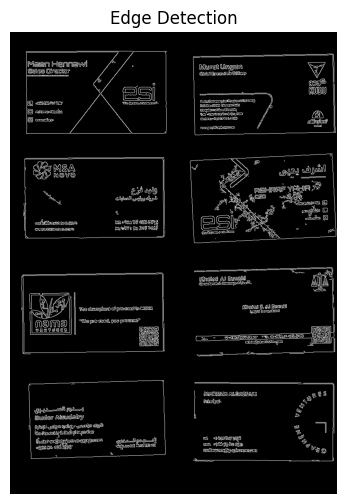

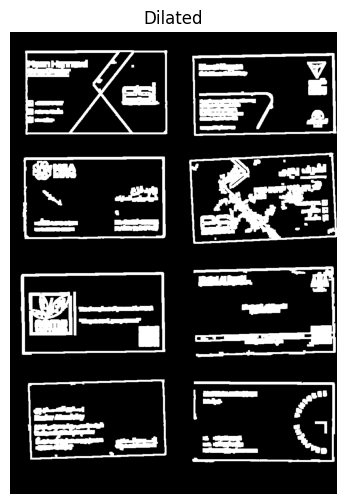

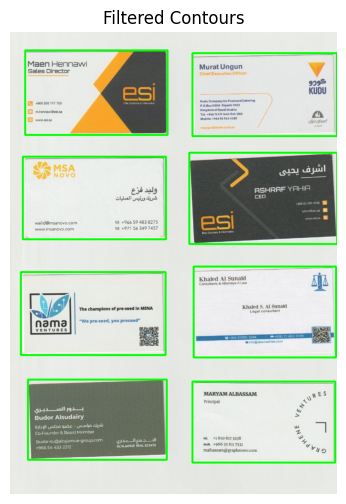

C:\Users\Aedukan\AppData\Local\Temp\ipykernel_31496\3539170743.py:57: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


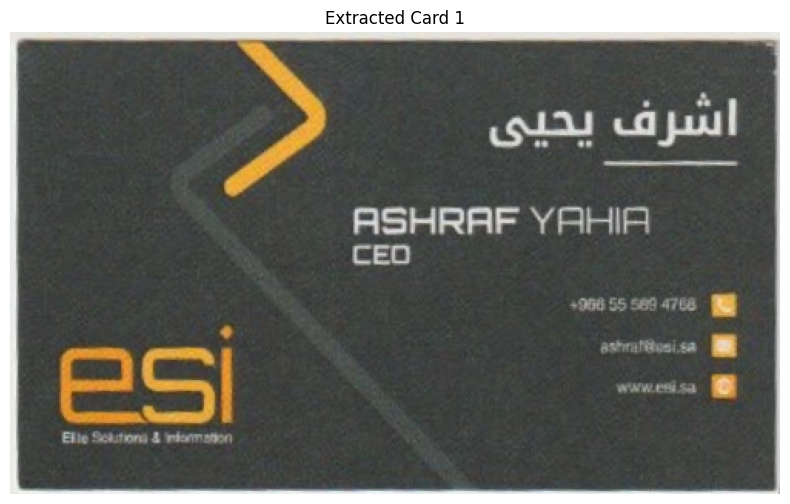

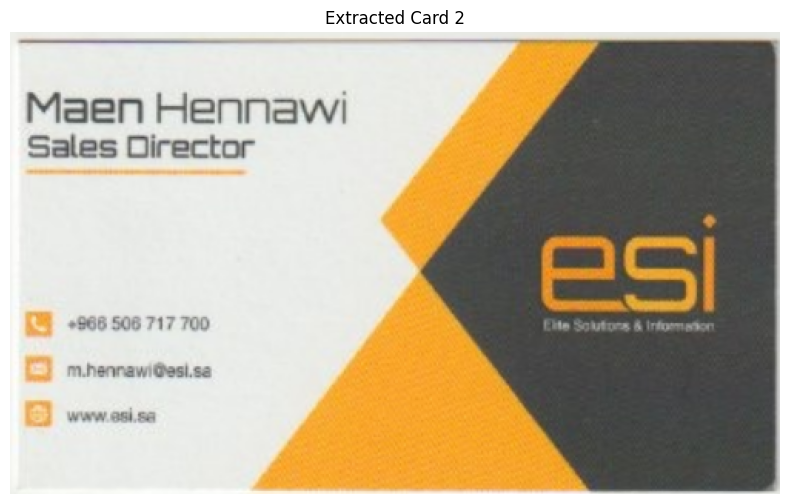

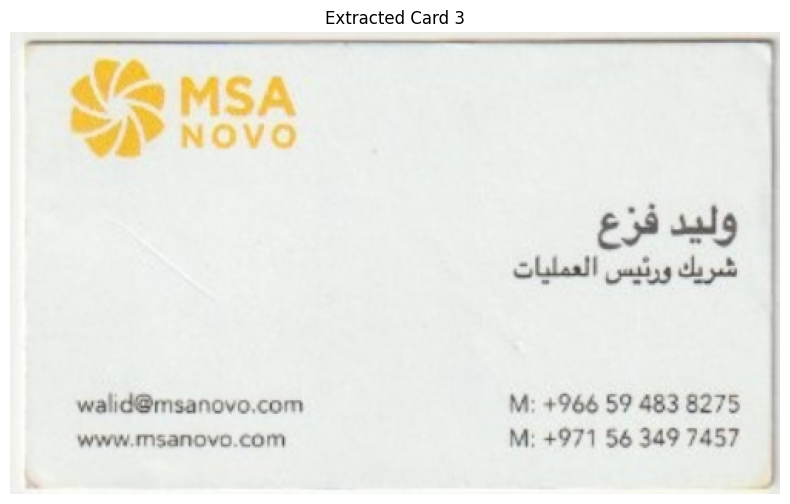

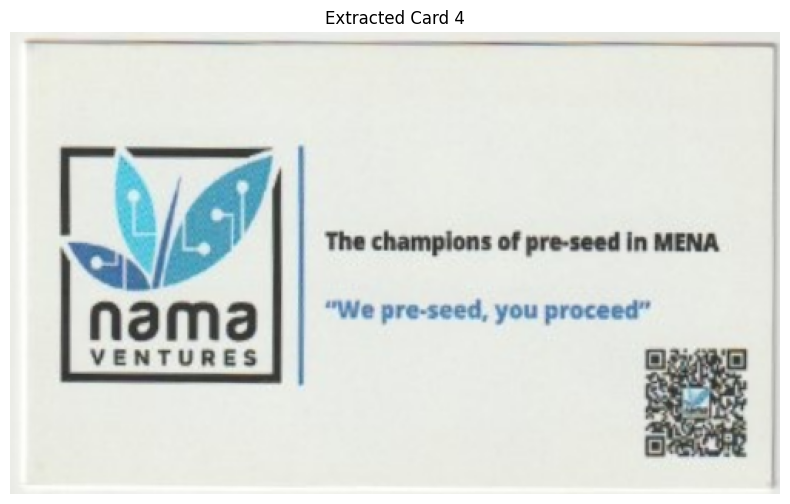

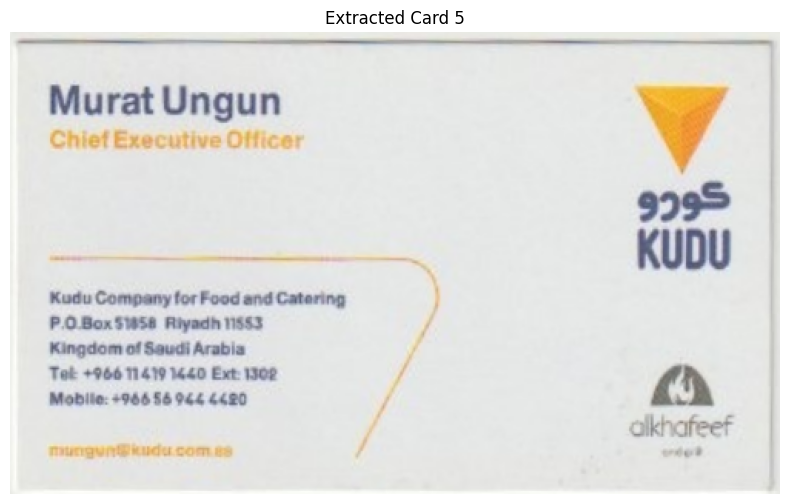

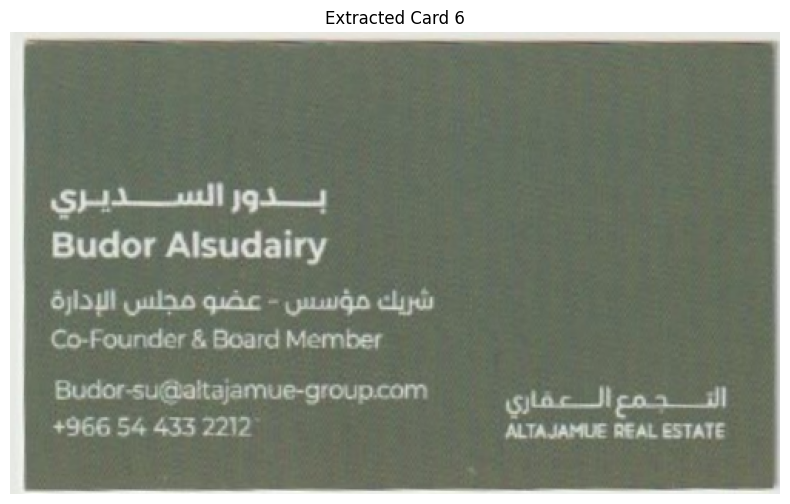

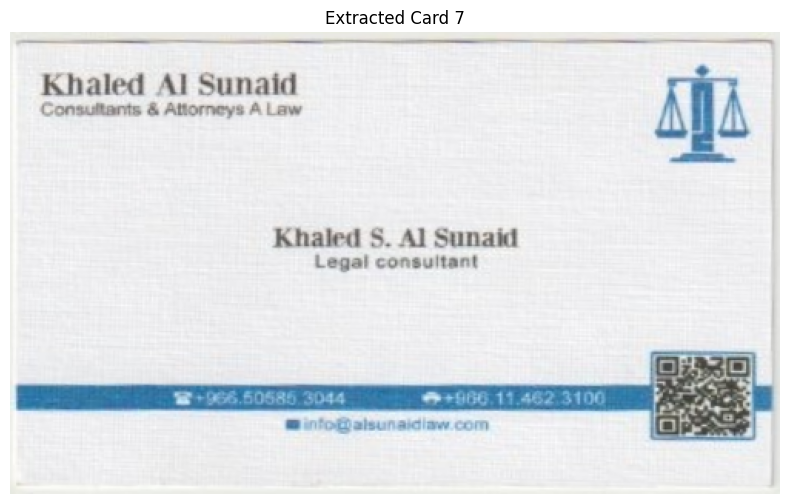

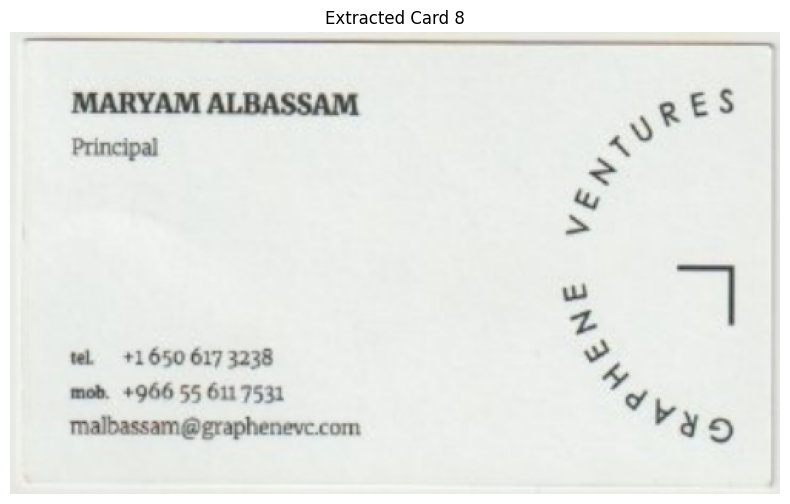

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to display images
def display_image(title, image):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Step 1: Read the image
image = cv2.imread('Cards0.jpeg')
# display_image('Original Image', image)

# Step 2: Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# display_image('Grayscale Image', gray)

# Step 3: Apply edge detection
edges = cv2.Canny(gray, 20, 100)
display_image('Edge Detection', edges)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated = cv2.dilate(edges, kernel, iterations=1)
display_image('Dilated', dilated)

# Step 4: Find contours
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoured_image = image.copy()

# Filter contours
filtered_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(h) / w
    area = cv2.contourArea(contour)
    if area > 4000:  # Adjust these thresholds as needed
        filtered_contours.append(contour)
        cv2.rectangle(contoured_image, (x, y), (x + w, y + h), (0, 255, 0), 3)

display_image('Filtered Contours', contoured_image)

# Sort contours by area (largest to smallest)
filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)

# Create a directory to save the extracted cards
import os
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to get the four corners of the contour
def get_contour_corners(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return box

# Step 5: Extract and save each card with transparent background
for i, contour in enumerate(filtered_contours):
    # Get the corners of the contour
    corners = get_contour_corners(contour)
    
    # Define the points for perspective transform
    width, height = 500, 300  # Size of the output card
    dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")
    
    # Order the contour points
    rect = np.zeros((4, 2), dtype="float32")
    s = corners.sum(axis=1)
    rect[0] = corners[np.argmin(s)]
    rect[2] = corners[np.argmax(s)]

    diff = np.diff(corners, axis=1)
    rect[1] = corners[np.argmin(diff)]
    rect[3] = corners[np.argmax(diff)]
    
    # Get the transformation matrix
    M = cv2.getPerspectiveTransform(rect, dst_points)
    
    # Warp the perspective to get a top-down view of the card
    warp = cv2.warpPerspective(image, M, (width, height))
    
    # Convert the warped image to have a transparent background
    warp_rgb = cv2.cvtColor(warp, cv2.COLOR_BGR2BGRA)
    warp_rgb[:, :, 3] = 255  # Set alpha channel to 255 (opaque)

    # Save the card image
    card_filename = os.path.join(output_dir, f'card_{i+1}.png')
    cv2.imwrite(card_filename, warp_rgb)
    display_image(f'Extracted Card {i+1}', warp_rgb)
